## Imports


In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from oqd_core.interface.atomic import (
    AtomicCircuit,
    Beam,
    Ion,
    Level,
    Phonon,
    Pulse,
    SequentialProtocol,
    System,
    Transition,
)

from oqd_trical.backend.qutip.base import QutipBackend

In [2]:
matplotlib.rcParams["figure.figsize"] = (12, 8)
matplotlib.rcParams["font.size"] = 20
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"

## Atomic Circuit


In [3]:
downstate = Level(
    principal=6,
    spin=1 / 2,
    orbital=0,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=0,
    spin_orbital_nuclear_magnetization=0,
    energy=2 * np.pi * 0,
    label="q0",
)
estate = Level(
    principal=5,
    spin=1 / 2,
    orbital=1,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=1,
    spin_orbital_nuclear_magnetization=-1,
    energy=2 * np.pi * 100,
    label="e0",
)

transitions = [
    Transition(
        level1=downstate, level2=estate, einsteinA=1, multipole="E1", label="q0->e0"
    ),
]


Yb171 = Ion(
    mass=171,
    charge=1,
    position=[0, 0, 0],
    levels=[downstate, estate],
    transitions=transitions,
)

COM_x = Phonon(energy=2 * np.pi * 0.1, eigenvector=[1, 0, 0])

system = System(
    ions=[
        Yb171,
    ],
    modes=[
        COM_x,
    ],
)

beam = Beam(
    transition=transitions[0],
    rabi=2 * np.pi * 1,
    detuning=0,
    phase=np.pi / 2,
    polarization=[1, 0, 0],
    wavevector=[0, 1, 0],
    target=0,
)

protocol = SequentialProtocol(
    sequence=[
        Pulse(beam=beam, duration=0.4004),
        Pulse(beam=beam, duration=0.1001),
        Pulse(beam=beam, duration=0.1001),
        Pulse(beam=beam, duration=0.1001),
    ]
)

circuit = AtomicCircuit(system=system, protocol=protocol)

### Serialization & Deserialization


In [4]:
import json

circuit_json = circuit.model_dump_json()
circuit_json = json.dumps(json.loads(circuit_json), indent=2)

with open("6a_example_sequential_repeat.json", "w") as f:
    f.write(circuit_json)

In [5]:
with open("6a_example_sequential_repeat.json", "r") as f:
    circuit_json = f.read()

assert AtomicCircuit.model_validate_json(circuit_json) == circuit

## Qutip Intepreter


In [6]:
backend = QutipBackend(solver_options=dict(progress_bar=True))

fock_cutoff = 10
experiment, hilbert_space = backend.compile(circuit, fock_cutoff)

### Results


In [7]:
result = backend.run(
    experiment,
    hilbert_space=hilbert_space,
    timestep=1e-4,
)

10.0%. Run time:   0.05s. Est. time left: 00:00:00:00
20.0%. Run time:   0.09s. Est. time left: 00:00:00:00
30.0%. Run time:   0.13s. Est. time left: 00:00:00:00
40.0%. Run time:   0.17s. Est. time left: 00:00:00:00
50.0%. Run time:   0.21s. Est. time left: 00:00:00:00
60.0%. Run time:   0.25s. Est. time left: 00:00:00:00
70.0%. Run time:   0.29s. Est. time left: 00:00:00:00
80.0%. Run time:   0.33s. Est. time left: 00:00:00:00
90.0%. Run time:   0.37s. Est. time left: 00:00:00:00
100.0%. Run time:   0.41s. Est. time left: 00:00:00:00
Total run time:   0.42s
10.1%. Run time:   0.02s. Est. time left: 00:00:00:00
20.1%. Run time:   0.04s. Est. time left: 00:00:00:00
30.1%. Run time:   0.05s. Est. time left: 00:00:00:00
40.1%. Run time:   0.07s. Est. time left: 00:00:00:00
50.0%. Run time:   0.08s. Est. time left: 00:00:00:00
60.0%. Run time:   0.10s. Est. time left: 00:00:00:00
70.0%. Run time:   0.12s. Est. time left: 00:00:00:00
80.0%. Run time:   0.13s. Est. time left: 00:00:00:00
90.

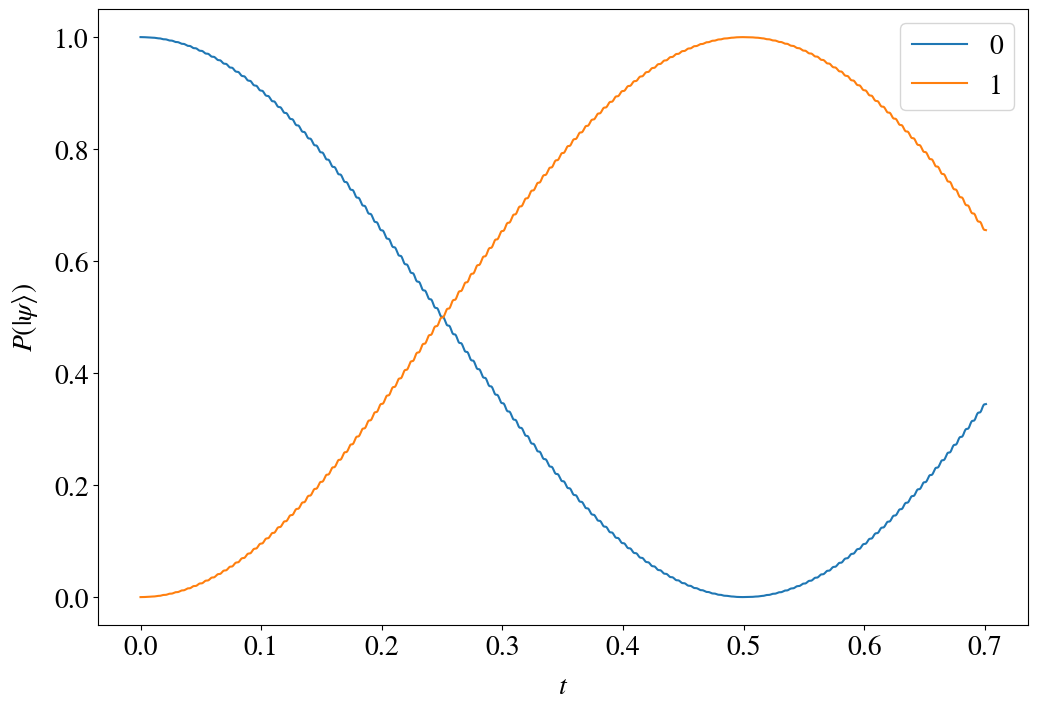

In [8]:
k = slice(None, None, 1)

fig = plt.figure()

ax = fig.subplots(1, 1, sharex=True)

ax.plot(
    result["tspan"][k],
    [s.ptrace(0).diag() for s in result["states"][k]],
    label=range(len(hilbert_space.hilbert_space["E0"])),
)

ax.set_xlabel(r"$t$", labelpad=10)
ax.set_ylabel(r"$P(| \psi \rangle)$", labelpad=10)

ax.legend()

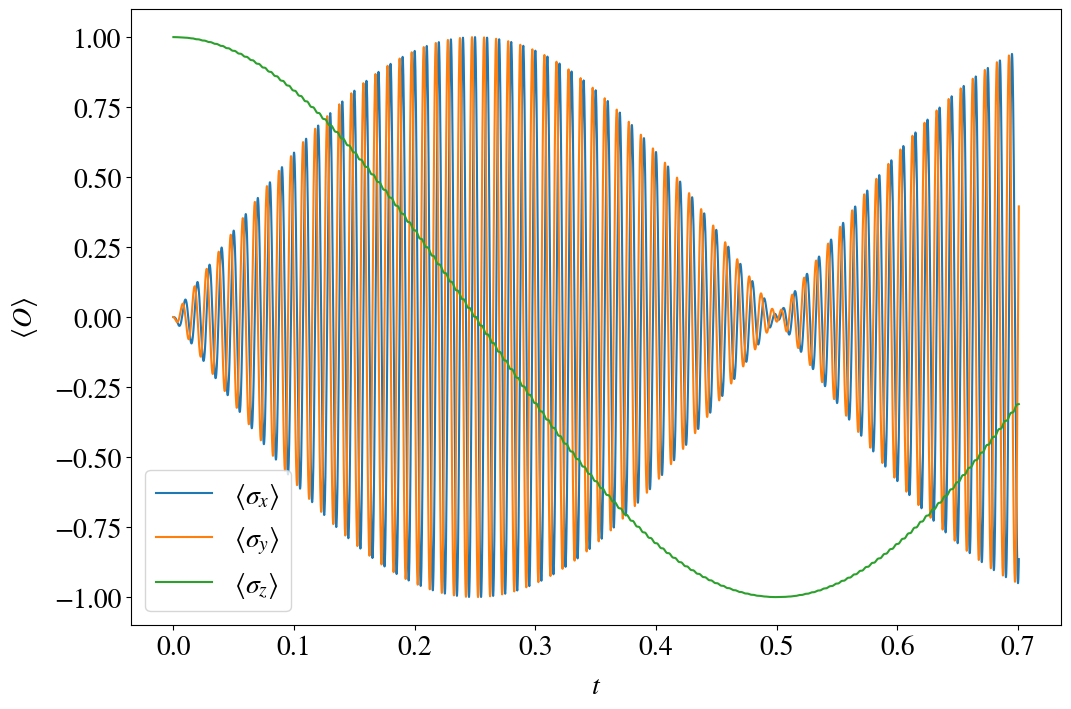

In [9]:
import qutip

k = slice(None, None, 1)

fig = plt.figure()

ax = fig.subplots(1, 1, sharex=True)

ax.plot(
    result["tspan"][k],
    [
        [
            qutip.expect(qutip.sigmax(), s.ptrace(0)),
            qutip.expect(qutip.sigmay(), s.ptrace(0)),
            qutip.expect(qutip.sigmaz(), s.ptrace(0)),
        ]
        for s in result["states"][k]
    ],
    label=[rf"$\langle \sigma_{alpha} \rangle$" for alpha in "xyz"],
)

ax.set_xlabel(r"$t$", labelpad=10)
ax.set_ylabel(r"$\langle O \rangle$", labelpad=10)

ax.legend()